In [11]:
import psychrnn
from psychrnn.tasks.task import Task
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.curriculum import Curriculum, default_metric
import numpy as np


In [13]:
class CDL(Task):
    def __init__(self, dt, tau, T, N_batch,delay_len):
        super(CDL, self).__init__(14, 2, dt, tau, T, N_batch)
        
        self.rule_mat = np.array([[0,1,1,0],
                                 [1,0,0,1],
                                 [0,1,1,1],
                                 [1,0,0,0],
                                 [0,0,0,1],
                                 [1,1,1,0],
                                 [0,0,1,1],
                                 [1,1,0,0],
                                 [0,1,0,1],
                                 [1,0,1,0]])
        
        self.delay_len = delay_len

    def generate_trial_params(self, batch, trial):
        """"Define parameters for each trial.

        Using a combination of randomness, presets, and task attributes, define the necessary trial parameters.

        Args:
            batch (int): The batch number that this trial is part of.
            trial (int): The trial number of the trial within the batch.

        Returns:
            dict: Dictionary of trial parameters.

        """

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['rule'] = np.random.choice([0,1,2,3,4,5,6,7,8,9])
        params['A'] = np.random.choice([0,1])
        params['B'] = np.random.choice([0,1])
        params['target'] = self.rule_mat[params['rule'],2*params['A']+params['B']]
        
        #params['coherence'] = np.random.exponential(scale=1/5)
        #params['direction'] = np.random.choice([0, 1])

        return params

    def trial_function(self, time, params):
        """ Compute the trial properties at the given time.

        Based on the params compute the trial stimulus (x_t), correct output (y_t), and mask (mask_t) at the given time.

        Args:
            time (int): The time within the trial (0 <= time < T).
            params (dict): The trial params produced generate_trial_params()

        Returns:
            tuple:

            x_t (ndarray(dtype=float, shape=(N_in,))): Trial input at time given params.
            y_t (ndarray(dtype=float, shape=(N_out,))): Correct trial output at time given params.
            mask_t (ndarray(dtype=bool, shape=(N_out,))): True if the network should train to match the y_t, False if the network should ignore y_t when training.

        """
        stim_noise = 0.01
        stim_dur = 100
        A_onset = 200
        B_onset = A_onset+stim_dur+self.delay_len

        # ----------------------------------
        # Initialize with noise
        # ----------------------------------
        x_t = np.sqrt(2*self.alpha*stim_noise*stim_noise)*np.random.randn(self.N_in)
        y_t = np.zeros(self.N_out)
        mask_t = np.ones(self.N_out)

        # ----------------------------------
        # Retrieve parameters
        # ----------------------------------
        rule = params['rule']
        A = params['A']
        B = params['B']
        target = params['target']

        # ----------------------------------
        # Compute values
        # ----------------------------------
        
        x_t[4+rule] += 1
        
        if A_onset < time < A_onset + stim_dur:
            x_t[A] += 1
            
        if B_onset < time < B_onset + stim_dur:
            x_t[2+B] += 1

        if time > B_onset:
            y_t[target] = 1.

        if time < B_onset:
            mask_t = np.zeros(self.N_out)

        return x_t, y_t, mask_t
    
    def accuracy_function(self, correct_output, test_output, output_mask):
        """Calculates the accuracy of :data:`test_output`.

        Implements :func:`~psychrnn.tasks.task.Task.accuracy_function`.

        Takes the channel-wise mean of the masked output for each trial. Whichever channel has a greater mean is considered to be the network's "choice".

        Returns:
            float: 0 <= accuracy <= 1. Accuracy is equal to the ratio of trials in which the network made the correct choice as defined above.
        
        """


        chosen = np.argmax(np.mean(test_output*output_mask, axis=1), axis = 1)
        truth = np.argmax(np.mean(correct_output*output_mask, axis = 1), axis = 1)
        return np.mean(np.equal(truth, chosen))

Iter 1280, Minibatch Loss= 0.268296
Iter 2560, Minibatch Loss= 0.212576
Iter 3840, Minibatch Loss= 0.191199
Iter 5120, Minibatch Loss= 0.179959
Iter 6400, Minibatch Loss= 0.171035
Iter 7680, Minibatch Loss= 0.164617
Iter 8960, Minibatch Loss= 0.162836
Optimization finished!


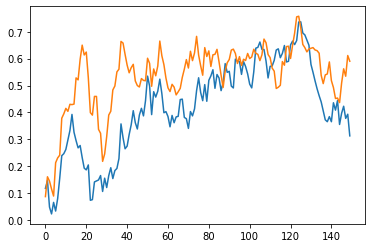

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

from psychrnn.backend.models.basic import Basic

# ---------------------- Set up a basic model ---------------------------
cdl = CDL(dt = 10, tau = 100, T = 1500, N_batch = 128, delay_len=400)
network_params = cdl.get_task_params() # get the params passed in and defined in pd
network_params['name'] = 'model' # name the model uniquely if running mult models in unison
network_params['N_rec'] = 50 # set the number of recurrent units in the model
network_params['rec_noise'] = 0.1

network_params['L1_in'] = 0.01 # Parameter for weighting the L1 input weights regularization. Default: 0.
network_params['L1_rec'] = 0.01 # Parameter for weighting the L1 recurrent weights regularization. Default: 0.
network_params['L1_out'] = 0.01 # Parameter for weighting the L1 output weights regularization. Default: 0.
network_params['L2_firing_rate'] = 1.

model = Basic(network_params) # instantiate a basic vanilla RNN

# ---------------------- Train a basic model ---------------------------
train_params = {}
train_params['training_iters'] = 10000
model.train(cdl,train_params) # train model to perform pd task

# ---------------------- Test the trained model ---------------------------
cdl_test = CDL(dt = 10, tau = 100, T = 1500, N_batch = 128, delay_len=400)
x,target_output,mask, trial_params = cdl_test.get_trial_batch() # get pd task inputs and outputs
model_output, model_state = model.test(x) # run the model on input x

# ---------------------- Plot the results ---------------------------
plt.plot(model_output[0,:,:])

# ---------------------- Teardown the model -------------------------
model.destruct()

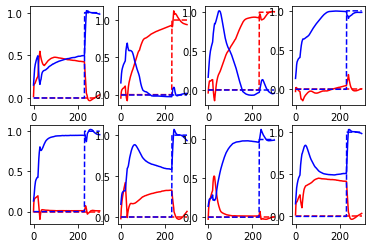

In [36]:
for ii in range(8):
    plt.subplot(2,4,ii+1)
    plt.plot(model_output[ii,:,0],'r')
    plt.plot(target_output[ii,:,0],'r--')

    plt.plot(model_output[ii,:,1],'b')
    plt.plot(target_output[ii,:,1],'b--')

In [37]:
np.mean(np.argmax(model_output[:,100,:],axis=1)==np.argmax(target_output[:,100,:],axis=1))

0.5078125

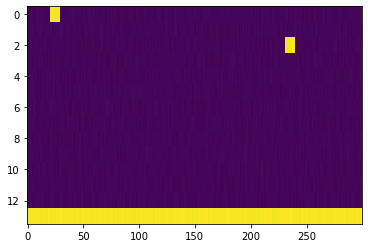

In [38]:
plt.imshow(x[0,:,:].T,aspect='auto',interpolation='nearest')

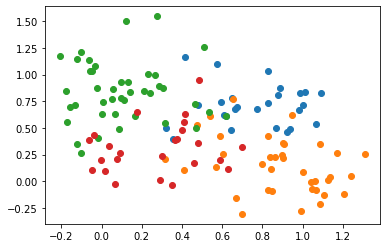

In [7]:
#contingency subspace
con_table = np.array([[1,2],
             [2,1],
             [1,3],
             [2,0],
             [0,1],
             [3,2],
             [0,3],
             [3,0],
             [1,1],
             [2,2]])

A = np.argmax(x[:,21,:2],axis=1)
R = np.argmax(x[:,0,4:],axis=1)
contingencies = np.zeros(len(A))
for ii in range(len(A)):
    contingencies[ii] = con_table[int(R[ii]),int(A[ii])]

X_ = model_state[:,69,:].T

y0_ = np.logical_or(contingencies==0,contingencies==1).astype('int').reshape(len(A),1)
y1_ = np.logical_or(contingencies==0,contingencies==2).astype('int').reshape(len(A),1)

w0 = np.linalg.inv(X_.dot(X_.T)).dot(X_).dot(y0_)
w1 = np.linalg.inv(X_.dot(X_.T)).dot(X_).dot(y1_)

for ii in range(4):
    plt.plot(X_.T.dot(w0)[contingencies==ii],X_.T.dot(w1)[contingencies==ii],'o')


In [8]:
network_params

{'N_batch': 128,
 'N_in': 14,
 'N_out': 2,
 'dt': 10,
 'tau': 100,
 'T': 1500,
 'alpha': 0.1,
 'N_steps': 150,
 'rule_mat': array([[0, 1, 1, 0],
        [1, 0, 0, 1],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 1, 1, 0],
        [0, 0, 1, 1],
        [1, 1, 0, 0],
        [0, 1, 0, 1],
        [1, 0, 1, 0]]),
 'delay_len': 400,
 'name': 'model',
 'N_rec': 50,
 'rec_noise': 0.1,
 'L1_in': 0.01,
 'L1_rec': 0.01,
 'L1_out': 0.01,
 'L2_firing_rate': 1.0}

In [9]:
model.destruct()

In [26]:
#curriculum learning 

delay_lengths = [400,600,800,1000,1200,1400,1600,1800,2000]
thresholds = [.99,.99,.99,.99,.99,.99,.99,.99,1.1]

task_list =  [CDL(dt = 10, tau = 100, T = 3000, N_batch = 128, delay_len=delay) for delay in delay_lengths]

curriculum = Curriculum(task_list, thresholds=thresholds)

network_params = task_list[0].get_task_params()
network_params['name'] = 'curriculumModel' #Used to scope out a namespace for global variables.
network_params['N_rec'] = 50


curriculumModel = Basic(network_params)

train_params = {}
train_params['training_iters'] = 200000
train_params['curriculum'] = curriculum

curric_losses, initialTime, trainTime = curriculumModel.train_curric(train_params)



Iter 1280, Minibatch Loss= 0.285287
Accuracy: 0.5234375
Iter 2560, Minibatch Loss= 0.247349
Accuracy: 0.5859375
Iter 3840, Minibatch Loss= 0.208388
Accuracy: 0.546875
Iter 5120, Minibatch Loss= 0.191724
Accuracy: 0.625
Iter 6400, Minibatch Loss= 0.175762
Accuracy: 0.5625
Iter 7680, Minibatch Loss= 0.163711
Accuracy: 0.6015625
Iter 8960, Minibatch Loss= 0.169105
Accuracy: 0.609375
Iter 10240, Minibatch Loss= 0.183879
Accuracy: 0.5546875
Iter 11520, Minibatch Loss= 0.170127
Accuracy: 0.6875
Iter 12800, Minibatch Loss= 0.162654
Accuracy: 0.703125
Iter 14080, Minibatch Loss= 0.145880
Accuracy: 0.6875
Iter 15360, Minibatch Loss= 0.149500
Accuracy: 0.6171875
Iter 16640, Minibatch Loss= 0.149288
Accuracy: 0.71875
Iter 17920, Minibatch Loss= 0.168132
Accuracy: 0.6640625
Iter 19200, Minibatch Loss= 0.157662
Accuracy: 0.6875
Iter 20480, Minibatch Loss= 0.165825
Accuracy: 0.7578125
Iter 21760, Minibatch Loss= 0.158948
Accuracy: 0.765625
Iter 23040, Minibatch Loss= 0.140308
Accuracy: 0.8203125
Ite

Accuracy: 1.0
Iter 193280, Minibatch Loss= 0.002791
Accuracy: 1.0
Iter 194560, Minibatch Loss= 0.002586
Accuracy: 1.0
Iter 195840, Minibatch Loss= 0.002708
Accuracy: 1.0
Iter 197120, Minibatch Loss= 0.002560
Accuracy: 1.0
Iter 198400, Minibatch Loss= 0.002715
Accuracy: 1.0
Iter 199680, Minibatch Loss= 0.002584
Accuracy: 1.0
Optimization finished!


In [28]:
# ---------------------- Test the trained model ---------------------------
cdl_test = CDL(dt = 10, tau = 100, T = 3000, N_batch = 128, delay_len=delay_lengths[-1])
x,target_output,mask, trial_params = cdl_test.get_trial_batch() # get pd task inputs and outputs
model_output, model_state = curriculumModel.test(x) # run the model on input x


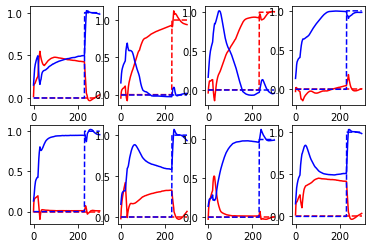

In [29]:
for ii in range(8):
    plt.subplot(2,4,ii+1)
    plt.plot(model_output[ii,:,0],'r')
    plt.plot(target_output[ii,:,0],'r--')

    plt.plot(model_output[ii,:,1],'b')
    plt.plot(target_output[ii,:,1],'b--')

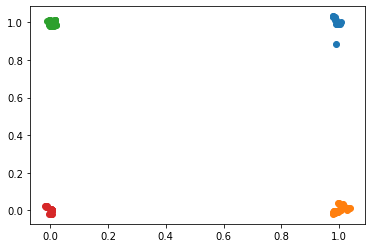

In [35]:
#contingency subspace
con_table = np.array([[1,2],
             [2,1],
             [1,3],
             [2,0],
             [0,1],
             [3,2],
             [0,3],
             [3,0],
             [1,1],
             [2,2]])

A = np.argmax(x[:,21,:2],axis=1)
R = np.argmax(x[:,0,4:],axis=1)
contingencies = np.zeros(len(A))
for ii in range(len(A)):
    contingencies[ii] = con_table[int(R[ii]),int(A[ii])]

X_ = model_state[:,200,:].T

y0_ = np.logical_or(contingencies==0,contingencies==1).astype('int').reshape(len(A),1)
y1_ = np.logical_or(contingencies==0,contingencies==2).astype('int').reshape(len(A),1)

w0 = np.linalg.inv(X_.dot(X_.T)+.1*np.eye(50)).dot(X_).dot(y0_)
w1 = np.linalg.inv(X_.dot(X_.T)+.1*np.eye(50)).dot(X_).dot(y1_)

for ii in range(4):
    plt.plot(X_.T.dot(w0)[contingencies==ii],X_.T.dot(w1)[contingencies==ii],'o')


In [25]:
curriculumModel.destruct()